<a href="https://colab.research.google.com/github/srimanthtenneti/Deep-Learning-NanoDegree/blob/main/Capsule_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsule Networks

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms , datasets
 # Configuring the seed
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

%matplotlib inline

transform = transforms.ToTensor()

In [146]:
# Fetching the dataset and the testset

trainset = datasets.MNIST('./root' , train = True  , download = True , transform = transform)
testset  = datasets.MNIST('./root' , train = False , download= True  , transform = transform)

# Defining the batch_size -> 32

batch_size  =32

# Defining the trainloader and testloader

train_loader = torch.utils.data.DataLoader(trainset , batch_size , shuffle = True)
test_loader  = torch.utils.data.DataLoader(testset  , batch_size)

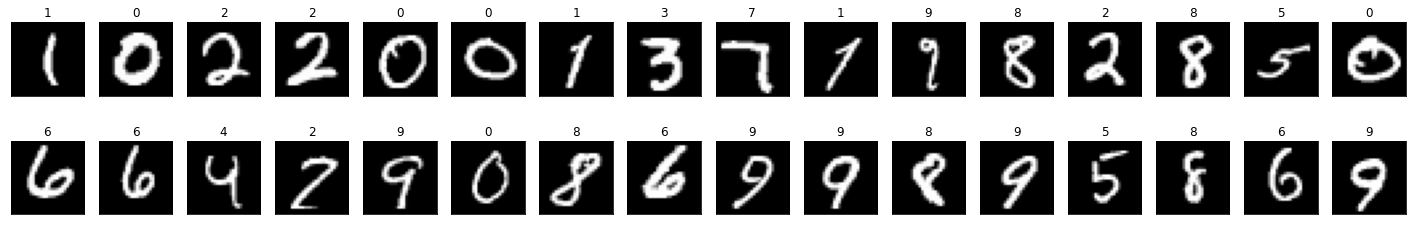

In [147]:
# Visualizing the data
dataiter = iter(train_loader)
images , labels = dataiter.next()
images , labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (25 , 4))

for i in range(batch_size):
  ax = fig.add_subplot(2 , batch_size/2 , i+1 , xticks = [] , yticks = [])
  ax.imshow(np.squeeze(images[i]) , cmap = 'gray')
  ax.set_title(labels[i])

### Encoder Architecture
The encoder for the capsule networks has 4 primary components. They are : 

1. Primary Convolutional layer
2. Secondary Capsule layer
3. Final Capsule layer
4. Dynamic routing via agreement 

In [148]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [149]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def forward(self, x):
        
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash
    
    def squash(self, input_tensor):
        
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [150]:
import torch
import torch.nn.functional as F

def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)


In [151]:
!nvidia-smi

Sun Aug  1 04:23:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |   1935MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [152]:
TRAIN_ON_GPU = torch.cuda.is_available()
if TRAIN_ON_GPU:
  print("GPU Accelerator available !!!")
else:
  print("No Acclerator available !!!")

GPU Accelerator available !!!


In [153]:
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j

In [154]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, 
                 in_channels=8, out_channels=16):
    
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
      
        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        # 4D weight matrix
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())
        
        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

### Decoder Architecture

1. This consists of three fully connected layers. 

In [155]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        super(Decoder, self).__init__()
        
        # calculate input_dim
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

In [156]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y

In [157]:
capsule_net = CapsuleNetwork()

print(capsule_net)

# move model to GPU, if available 
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

### Defining the Custom Losses

1. In a capsule network the loss function is a weighted combination of 2 losses. They are : 
 
  1. Margin Loss
  2. Reconstruction Loss

1. Margin Loss
  image.png

* Reconstruction loss is just MSE

In [158]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
       
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):

        batch_size = x.size(0)

        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [159]:
import torch.optim as optim
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [160]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=300):
    # track training loss over time
    losses = []

    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):

            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses

In [161]:
n_epochs = 3
losses = train(capsule_net , criterion , optimizer , n_epochs = n_epochs)

Epoch: 1 	Training Loss: 0.23821404
Epoch: 1 	Training Loss: 0.07673883
Epoch: 1 	Training Loss: 0.06182283
Epoch: 1 	Training Loss: 0.05404992
Epoch: 1 	Training Loss: 0.04801133
Epoch: 1 	Training Loss: 0.04637082
Epoch: 2 	Training Loss: 0.03715339
Epoch: 2 	Training Loss: 0.03313834
Epoch: 2 	Training Loss: 0.03463684
Epoch: 2 	Training Loss: 0.03523171
Epoch: 2 	Training Loss: 0.03359433
Epoch: 2 	Training Loss: 0.03405389
Epoch: 3 	Training Loss: 0.02692540
Epoch: 3 	Training Loss: 0.02425742
Epoch: 3 	Training Loss: 0.02649624
Epoch: 3 	Training Loss: 0.02639780
Epoch: 3 	Training Loss: 0.02617035
Epoch: 3 	Training Loss: 0.02561075


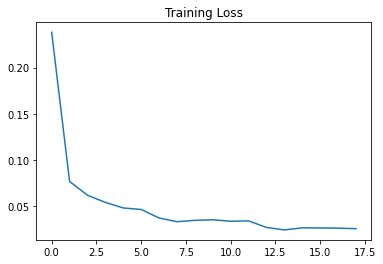

In [162]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [163]:
def test(capsule_net, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    test_loss = 0 # loss tracking

    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)

        batch_size = images.size(0)

        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [164]:
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.02731027

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 99% (1025/1032)
Test Accuracy of     3: 99% (1006/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 99% (888/892)
Test Accuracy of     6: 99% (949/958)
Test Accuracy of     7: 99% (1020/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 99% (1001/1009)

Test Accuracy (Overall): 99% (9938/10000)


In [166]:
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.1,0.1)),
     transforms.ToTensor()]
    )

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, 
                                                      batch_size=batch_size,
                                                      num_workers=0)

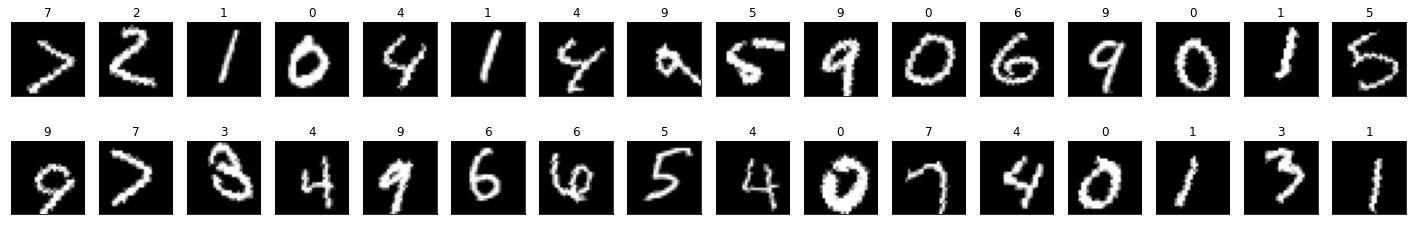

In [167]:
dataiter = iter(transformed_test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [168]:
_, images, reconstructions = test(capsule_net, transformed_test_loader)

Test Loss: 0.26425424

Test Accuracy of     0: 87% (856/980)
Test Accuracy of     1: 93% (1058/1135)
Test Accuracy of     2: 85% (882/1032)
Test Accuracy of     3: 90% (910/1010)
Test Accuracy of     4: 83% (820/982)
Test Accuracy of     5: 91% (814/892)
Test Accuracy of     6: 85% (820/958)
Test Accuracy of     7: 77% (792/1028)
Test Accuracy of     8: 74% (721/974)
Test Accuracy of     9: 80% (815/1009)

Test Accuracy (Overall): 84% (8488/10000)
